In [1]:
import cv2

full_model_path = "./yolov5s.onnx"
opencv_net = cv2.dnn.readNetFromONNX(full_model_path)

In [6]:
# This code was taken from another repo (cv2 onnx inference)
import numpy as np
import cv2

class yolov5():
    def __init__(self, confThreshold=0.5, nmsThreshold=0.5, objThreshold=0.5):
        anchors = [[4,5,  8,10,  13,16], [23,29,  43,55,  73,105], [146,217,  231,300,  335,433]]
        num_classes = 1
        self.nl = len(anchors)
        self.na = len(anchors[0]) // 2
        self.no = num_classes + 5 + 10
        self.grid = [np.zeros(1)] * self.nl
        self.stride = np.array([8., 16., 32.])
        self.anchor_grid = np.asarray(anchors, dtype=np.float32).reshape(self.nl, -1, 2)
        self.inpWidth = 640
        self.inpHeight = 640
        # self.net = cv2.dnn.readNet(yolo_type+'-face.onnx')
        self.net = cv2.dnn.readNet("./yolov5s.onnx")
        self.confThreshold = confThreshold
        self.nmsThreshold = nmsThreshold
        self.objThreshold = objThreshold

    def _make_grid(self, nx=20, ny=20):
        xv, yv = np.meshgrid(np.arange(ny), np.arange(nx))
        return np.stack((xv, yv), 2).reshape((-1, 2)).astype(np.float32)

    def postprocess(self, frame, outs):
        frameHeight = frame.shape[0]
        frameWidth = frame.shape[1]
        ratioh, ratiow = frameHeight / self.inpHeight, frameWidth / self.inpWidth
        # Scan through all the bounding boxes output from the network and keep only the
        # ones with high confidence scores. Assign the box's class label as the class with the highest score.

        confidences = []
        boxes = []
        landmarks = []
        for detection in outs:
            confidence = detection[15]
            # if confidence > self.confThreshold and detection[4] > self.objThreshold:
            if detection[4] > self.objThreshold:
                center_x = int(detection[0] * ratiow)
                center_y = int(detection[1] * ratioh)
                width = int(detection[2] * ratiow)
                height = int(detection[3] * ratioh)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)

                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
                landmark = detection[5:15] * np.tile(np.float32([ratiow,ratioh]), 5)
                landmarks.append(landmark.astype(np.int32))
        # Perform non maximum suppression to eliminate redundant overlapping boxes with
        # lower confidences.
        indices = cv2.dnn.NMSBoxes(boxes, confidences, self.confThreshold, self.nmsThreshold)
        for i in indices:
            i = i[0]
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            landmark = landmarks[i]
            frame = self.drawPred(frame, confidences[i], left, top, left + width, top + height, landmark)
        return frame
    def drawPred(self, frame, conf, left, top, right, bottom, landmark):
        # Draw a bounding box.
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), thickness=2)
        # label = '%.2f' % conf
        # Display the label at the top of the bounding box
        # labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        # top = max(top, labelSize[1])
        # cv2.putText(frame, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2)
        for i in range(5):
            cv2.circle(frame, (landmark[i*2], landmark[i*2+1]), 1, (0,255,0), thickness=-1)
        return frame
    def detect(self, srcimg, custom=True):
        if custom:
            input_img = cv2.imread(srcimg)
# input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            # input_img = input_img.astype(np.float32)
            input_img = input_img.astype(np.float32)
            # input_img = cv2.resize(input_img, (640, 640))

            mean = np.array([0.485, 0.456, 0.406]) * 255.0
            scale = 1 / 255.0
            std = [0.229, 0.224, 0.225]

            input_blob = cv2.dnn.blobFromImage(
                image=input_img,
                scalefactor=scale,
                size=(640, 640),  # img target size
                mean=mean,
                swapRB=True,  # BGR -> RGB
                crop=True  # center crop
            )
        else:
            blob = cv2.dnn.blobFromImage(srcimg, 1 / 255.0, (self.inpWidth, self.inpHeight), [0, 0, 0], swapRB=True, crop=False)
            # Sets the input to the network
            self.net.setInput(blob)

            # Runs the forward pass to get output of the output layers
            outs = self.net.forward(self.net.getUnconnectedOutLayersNames())[0]

        # inference output
        outs[..., [0,1,2,3,4,15]] = 1 / (1 + np.exp(-outs[..., [0,1,2,3,4,15]]))   ###sigmoid
        row_ind = 0
        for i in range(self.nl):
            h, w = int(self.inpHeight/self.stride[i]), int(self.inpWidth/self.stride[i])
            length = int(self.na * h * w)
            if self.grid[i].shape[2:4] != (h,w):
                self.grid[i] = self._make_grid(w, h)
            
            g_i = np.tile(self.grid[i], (self.na, 1))
            a_g_i = np.repeat(self.anchor_grid[i], h * w, axis=0)
            outs[row_ind:row_ind + length, 0:2] = (outs[row_ind:row_ind + length, 0:2] * 2. - 0.5 + g_i) * int(self.stride[i])
            outs[row_ind:row_ind + length, 2:4] = (outs[row_ind:row_ind + length, 2:4] * 2) ** 2 * a_g_i

            outs[row_ind:row_ind + length, 5:7] = outs[row_ind:row_ind + length, 5:7] * a_g_i + g_i * int(self.stride[i])   # landmark x1 y1
            outs[row_ind:row_ind + length, 7:9] = outs[row_ind:row_ind + length, 7:9] * a_g_i + g_i * int(self.stride[i])  # landmark x2 y2
            outs[row_ind:row_ind + length, 9:11] = outs[row_ind:row_ind + length, 9:11] * a_g_i + g_i * int(self.stride[i])  # landmark x3 y3
            outs[row_ind:row_ind + length, 11:13] = outs[row_ind:row_ind + length, 11:13] * a_g_i + g_i * int(self.stride[i])  # landmark x4 y4
            outs[row_ind:row_ind + length, 13:15] = outs[row_ind:row_ind + length, 13:15] * a_g_i + g_i * int(self.stride[i])  # landmark x5 y5
            row_ind += length
        return outs


In [7]:
detector = yolov5()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'blobFromImage'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


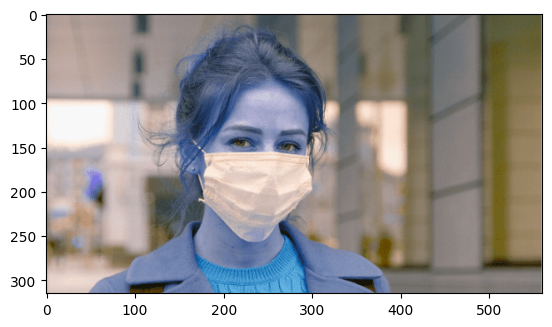

In [10]:
img_path = "../../../thesis_exportable_module/images/test_images/Masked.png"

import matplotlib.pyplot as plt

plt.imshow(cv2.imread(img_path))
detector.detect(img_path)

In [24]:
import numpy as np
img_path = "../../../thesis_exportable_module/images/test_images/Masked.png"

input_img = cv2.imread(img_path)
# input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
# input_img = input_img.astype(np.float32)
input_img = input_img.astype(np.float32)
# input_img = cv2.resize(input_img, (640, 640))

mean = np.array([0.485, 0.456, 0.406]) * 255.0
scale = 1 / 255.0
std = [0.229, 0.224, 0.225]

input_blob = cv2.dnn.blobFromImage(
    image=input_img,
    scalefactor=scale,
    size=(640, 640),  # img target size
    mean=mean,
    swapRB=True,  # BGR -> RGB
    crop=True  # center crop
)

# input_blob[0] /= np.asarray(std, dtype=np.float32).reshape(3, 1, 1)

In [25]:
input_blob.shape

(1, 3, 640, 640)

In [27]:
# set OpenCV DNN input
opencv_net.setInput(input_blob)
# OpenCV DNN inference
out = opencv_net.forward()
print("OpenCV DNN prediction: \n")
print("* shape: ", out.shape)
# get the predicted class ID
imagenet_class_id = np.argmax(out)

print(out)
# get confidence
# confidence = out[0][imagenet_class_id]
# print("* class ID: {}, label: {}".format(imagenet_class_id, imagenet_labels[imagenet_class_id]))
# print("* confidence: {:.4f}".format(confidence))

OpenCV DNN prediction: 

* shape:  (1, 25200, 85)
[[[3.02064991e+00 3.22792292e+00 8.33428478e+00 ... 2.68117571e-03
   8.36981868e-04 3.72020272e-03]
  [1.20037565e+01 3.88165426e+00 2.33986549e+01 ... 2.54754908e-03
   1.11414737e-03 3.51668289e-03]
  [1.80294170e+01 3.98224783e+00 2.99941235e+01 ... 2.83361017e-03
   1.08016958e-03 3.63892992e-03]
  ...
  [5.71000549e+02 6.02338440e+02 1.38688034e+02 ... 9.37875186e-04
   8.97429185e-04 7.67146936e-04]
  [5.80927917e+02 6.05206055e+02 1.18052246e+02 ... 1.15931197e-03
   8.13920982e-04 7.85825425e-04]
  [6.17623047e+02 6.17795959e+02 1.31520966e+02 ... 1.63118774e-03
   9.90892993e-04 1.01966900e-03]]]


In [28]:
out.shape

(1, 25200, 85)